## Reconstrucción del árbol filogenético

In [24]:
from Bio import AlignIO
from Bio.Align.Applications import ClustalOmegaCommandline
import Bio.Phylo as Phylo

from Bio.Phylo.TreeConstruction import ParsimonyScorer, NNITreeSearcher, ParsimonyTreeConstructor
from Bio.Phylo.Newick import Tree

from matplotlib import pyplot as plt

## Construcción del árbol filogenético (Virus Dengue-4)

Vamos a construir un árbol filogenético que nos permita conocer la taxonomía de los virus Dengue-4 en distintos países, atendiendo para ello a la secuencia de nucleótidos codificantes del dominio III de la proteína de envoltura (E) del mismo.

In [25]:
def align_sequences(input_fasta, output_fasta, output_format="fasta"):
    clustalomega_cline = ClustalOmegaCommandline(
        infile=input_fasta,
        outfile=output_fasta,
        verbose=True,
        auto=True,
        force=True
    )
    
    print(f"Ejecutando Clustal Omega...\n{clustalomega_cline}")
    clustalomega_cline()

    alignment = AlignIO.read(output_fasta, output_format)
    print(f"Alineamiento completado. Guardado en: {output_fasta}")
    
    return alignment

In [26]:
fasta_file = "processed_files/sequences_processed.fasta"
aligned_file = "processed_files/sequences_aligned.fasta"

alignment = align_sequences(fasta_file, aligned_file)

Ejecutando Clustal Omega...
clustalo -i processed_files/sequences_processed.fasta -o processed_files/sequences_aligned.fasta --auto -v --force
Alineamiento completado. Guardado en: processed_files/sequences_aligned.fasta


In [27]:
alignment = AlignIO.read(aligned_file, "fasta")

scorer = ParsimonyScorer()
searcher = NNITreeSearcher(scorer)
constructor = ParsimonyTreeConstructor(searcher)

parsimonious_tree = constructor.build_tree(alignment)

In [28]:
def remove_inner_labels(tree):
    for clade in tree.find_clades():
        if not clade.is_terminal():
            clade.name = None

def plot_tree(tree, branch_width=2, title="Árbol filogenético", size=(7,12)):
    remove_inner_labels(tree)
    
    plt.figure(figsize=size)
    ax = plt.gca()

    Phylo.draw(
        tree,
        axes=ax,
        do_show=False
    )

    for line in ax.findobj(match=lambda obj: isinstance(obj, plt.Line2D)):
        line.set_linewidth(branch_width)

    plt.title(title)
    plt.axis("off")
    plt.show()


El árbol filogenético obtenido es el siguiente:

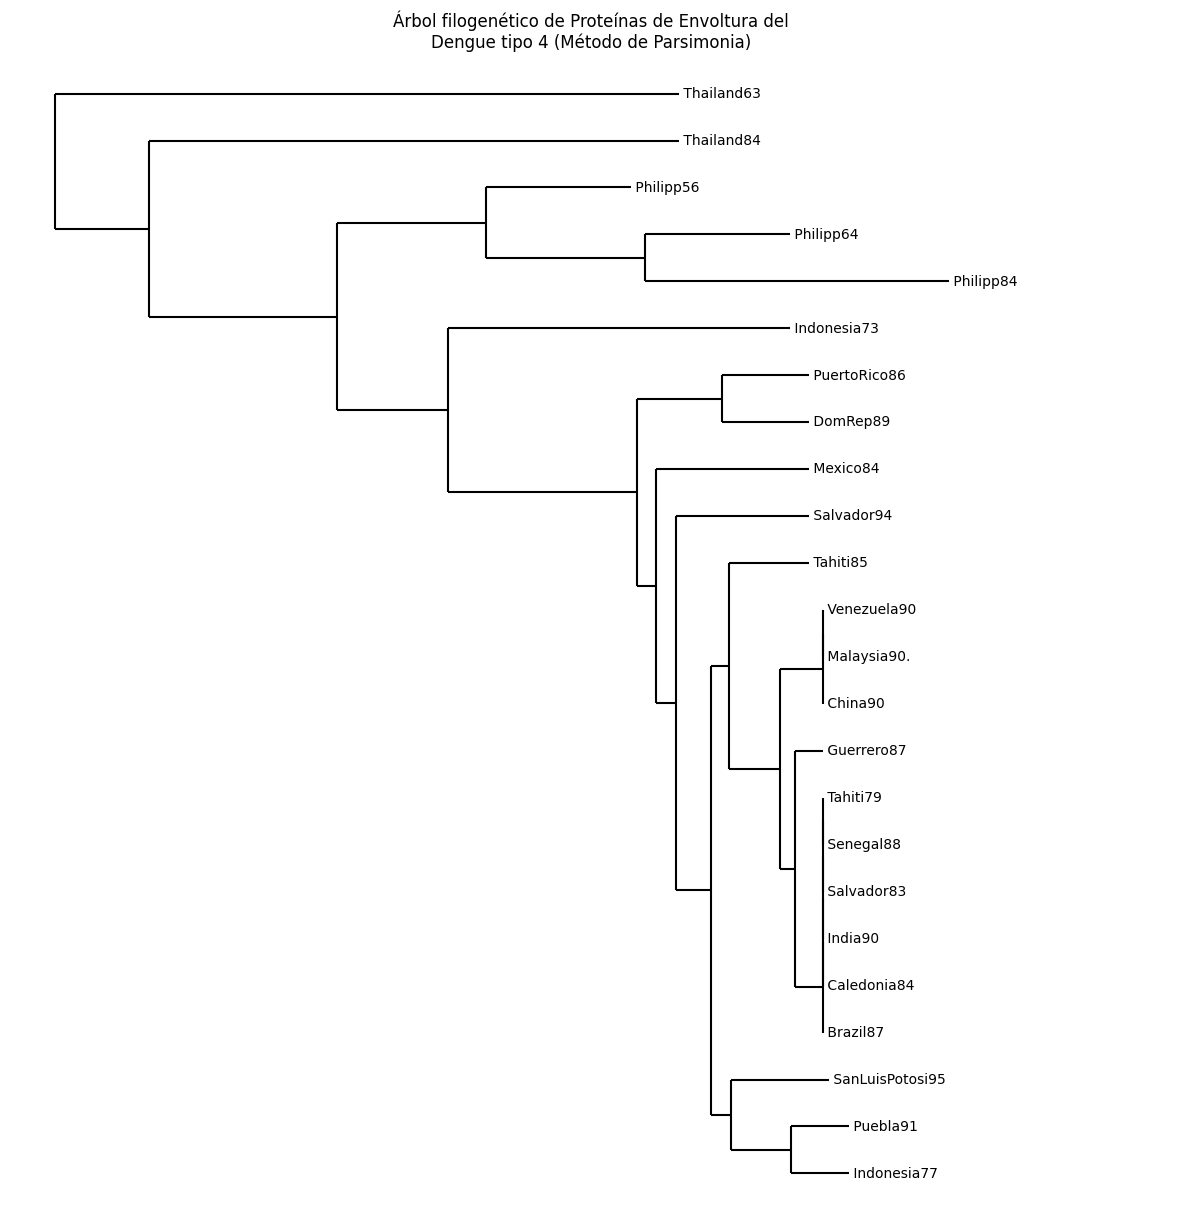

In [29]:
plot_tree(parsimonious_tree, 
          title="Árbol filogenético de Proteínas de Envoltura del\nDengue tipo 4 (Método de Parsimonia)",
          size=(15, 15))

## Construcción del árbol filogenético con Varias Variantes

A continuación, se muestra el árbol filogenético obtenido tras añadir tres variantes del virus, Dengue-1, Dengue-2 y Dengue-3, para comparar la similitud entre las proteínas de envoltura de los distintos virus Dengue.

In [81]:
fasta_file = "processed_files/sequences_processed_add.fasta"
aligned_file = "processed_files/sequences_aligned_add.fasta"

alignment = align_sequences(fasta_file, aligned_file)

Ejecutando Clustal Omega...
clustalo -i processed_files/sequences_processed_add.fasta -o processed_files/sequences_aligned_add.fasta --auto -v --force
Alineamiento completado. Guardado en: processed_files/sequences_aligned_add.fasta


In [82]:
alignment = AlignIO.read(aligned_file, "fasta")

scorer = ParsimonyScorer()
searcher = NNITreeSearcher(scorer)
constructor = ParsimonyTreeConstructor(searcher)

parsimonious_tree = constructor.build_tree(alignment)

En el árbol filogenético se aprecia como las variantes consiguen agruparse por tipo de virus, lo que indica que la secuencia de nucleótidos codificantes del dominio III de la proteína de envoltura (E) es suficiente para diferenciar entre los distintos tipos de virus Dengue. Además, vemos como las variantes de Dengue-2 y Dengue-3 son más cercanas entre sí que con las variantes de Dengue-1 y Dengue-4, aunque no tan similares como lo son las mutaciones de Dengue-4 entre sí.

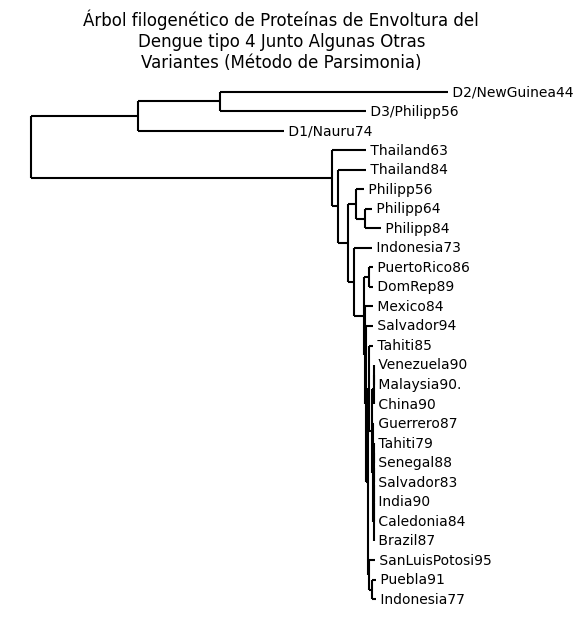

In [83]:
plot_tree(parsimonious_tree, 
          title="Árbol filogenético de Proteínas de Envoltura del\nDengue tipo 4 Junto Algunas Otras\nVariantes (Método de Parsimonia)",
          size=(7, 7))

## Búsqueda de Homólogos

In [51]:
from Bio.Blast import NCBIWWW, NCBIXML
import pandas as pd

In [52]:
class FastaDataLoader():
    def __init__(self):
        pass

    def load(self, filename):
        lines = []
        with open(filename, "r") as file:
            lines = file.readlines()

        return ''.join(lines[1:]).replace("\n", "")

In [53]:
laoder = FastaDataLoader()

In [54]:
sequence = laoder.load("fasta_files/tailan63.fasta")

In [55]:
print("Secuencia:", sequence)

Secuencia: ATGTGCTCAGGAAAGTTCTCAATTGACAAAGAGATGGCAGAAACACAGCATGGGACAACAGTAGTGAAAGTTAAGTATGAAGGCGCTGAAGCTCCATGTAAAATCCCCATAGAGATAAGAGATGTGAACAAGGAAAAAGTTGTTGGGCGCATCATCTCATCCACTCCTTTGGCTGAAAACACCAACAGCGTGACCAATATAGAATTAGAACCTCCCTTTGGGGACAGCTACATAGTAATAGGTGTTGGAGACAGTGCATTAACACTCCATTGGTTCAGGAAG


**Búsqueda de Homólogos**:
   - Se utiliza la función `search_online_sequences` para realizar búsquedas BLASTX contra la base de datos NR usando las secuencias cargadas. 
   - Los resultados se procesan para extraer información clave como el organismo de origen, la longitud de la alineación, el valor E y la puntuación (score) de los alineamientos.

In [67]:
def search_online_sequences(sequence):
    result = NCBIWWW.qblast("blastx", "nr", sequence)
    blast_records = NCBIXML.read(result)

    data = []

    if not blast_records.alignments:
        print("No se encontraron resultados.")
        return pd.DataFrame()
    
    for alignment in blast_records.alignments:
        organism = alignment.title
        sequence_data = alignment.hsps[0].align_length
        e_value = alignment.hsps[0].expect
        score = alignment.hsps[0].score
        
        data.append({
            "Organismo": organism,
            "Secuencia": sequence_data,
            "E-value": e_value,
            "Score": score
        })
    
    if not data:
        print(f"No se encontraron resultados.")
        return pd.DataFrame()
    
    df = pd.DataFrame(data)
    return df

In [ ]:
df_homolog = search_online_sequences(sequence)

**Ordenación y Filtrado de Resultados**:
   - Los resultados de BLAST se ordenan por el valor E, priorizando las alineaciones más significativas.
   - Se identifican y filtran los homólogos presentes en Homo sapiens para analizar aquellos más cercanos en términos evolutivos.

In [60]:
df_homolog = df_homolog.sort_values(by="E-value", ascending=True)
df_homolog.head(30)

,Organismo,Secuencia,E-value,Score
0,"pdb|3WE1|A Chain A, Envelope protein E [Dengue...",94,1.182900e-60,485.0
1,"pdb|2H0P|A Chain A, Envelope glycoprotein [den...",94,1.327490e-60,485.0
2,"pdb|3UYP|B Chain B, Envelope protein [dengue v...",94,1.339530e-60,485.0
3,"pdb|5AAM|C Chain C, ENVELOPE PROTEIN [Dengue v...",94,1.685220e-60,484.0
4,"gb|AAC05986.1| envelope protein, partial [deng...",94,1.871040e-60,482.0
5,"gb|AGW23581.1| envelope protein, partial [deng...",94,2.154900e-60,492.0
6,"gb|AGW23582.1| envelope protein, partial [deng...",94,2.205520e-60,492.0
7,"gb|AGW23590.1| envelope protein, partial [deng...",94,2.433750e-60,492.0
8,"gb|AGW23587.1| envelope protein, partial [deng...",94,2.453870e-60,492.0
9,"gb|AGW23589.1| envelope protein, partial [deng...",94,2.605710e-60,491.0


In [86]:
ids = []

for organism in df_homolog['Organismo'].head(70):
    print(organism)
    ids.append(organism.split("|")[1])

pdb|3WE1|A Chain A, Envelope protein E [Dengue virus 4 Dominica/814669/1981] >pdb|3WE1|B Chain B, Envelope protein E [Dengue virus 4 Dominica/814669/1981]
pdb|2H0P|A Chain A, Envelope glycoprotein [dengue virus type 4]
pdb|3UYP|B Chain B, Envelope protein [dengue virus type 4]
pdb|5AAM|C Chain C, ENVELOPE PROTEIN [Dengue virus] >pdb|5AAM|J Chain J, ENVELOPE PROTEIN [Dengue virus] >pdb|5AAW|C Chain C, DENGUE SEROTYPE 4 ENVELOPE PROTEIN DOMAIN 3 [Dengue virus] >pdb|5AAW|E Chain E, DENGUE SEROTYPE 4 ENVELOPE PROTEIN DOMAIN 3 [Dengue virus] >pdb|5AAW|G Chain G, DENGUE SEROTYPE 4 ENVELOPE PROTEIN DOMAIN 3 [Dengue virus] >pdb|5AAW|I Chain I, DENGUE SEROTYPE 4 ENVELOPE PROTEIN DOMAIN 3 [Dengue virus] >pdb|5AAW|J Chain J, DENGUE SEROTYPE 4 ENVELOPE PROTEIN DOMAIN 3 [Dengue virus] >pdb|5AAW|L Chain L, DENGUE SEROTYPE 4 ENVELOPE PROTEIN DOMAIN 3 [Dengue virus]
gb|AAC05986.1| envelope protein, partial [dengue virus type 4] >gb|AAC05988.1| envelope protein, partial [dengue virus type 4] >gb|AAC059

In [87]:
' '.join(ids)

'3WE1 2H0P 3UYP 5AAM AAC05986.1 AGW23581.1 AGW23582.1 AGW23590.1 AGW23587.1 AGW23589.1 AGW23588.1 AAC05987.1 AGW23586.1 5B1C AGW23585.1 ANW48413.1 AFK24730.1 AGW23583.1 AGW23584.1 4BZ1 4AM0 4BZ2 4X42 AHK14431.1 AJW83591.1 CUX99972.2 AAB70691.1 AJW83594.1 UJS00892.1 UAY85934.1 AJW83592.1 BCG29769.1 AET37153.1 QCE20720.1 BAM62634.1 QCE20721.1 QJD57119.1 7A3Q WRR49967.1 UUU47669.1 ANN30214.1 WRR49972.1 WRR49943.1 AEX97808.1 ANI24482.1 ANI24481.1 ANN30215.1 WHE55230.1 ANI24480.1 ANN30206.1'

Si buscamos, por ejemplo, la proteína 3WE1 en GenBank, obtenemos lo siguiente:

```
LOCUS       AAC05986                  94 aa            linear   VRL 25-JUL-2016
DEFINITION  envelope protein, partial [dengue virus type 4].
ACCESSION   AAC05986
VERSION     AAC05986.1
DBSOURCE    accession AF051104.1
KEYWORDS    .
SOURCE      dengue virus type 4
  ORGANISM  dengue virus type 4
            Viruses; Riboviria; Orthornavirae; Kitrinoviricota; Flasuviricetes;
            Amarillovirales; Flaviviridae; Orthoflavivirus; Orthoflavivirus
            denguei.
REFERENCE   1  (residues 1 to 94)
  AUTHORS   Mota,J., Ramos-Castaneda,J., Rico-Hesse,R. and Ramos,C.
  TITLE     Phylogenetic analysis of the envelope protein (domain III) of
            Dengue-4 viruses
  JOURNAL   Unpublished
REFERENCE   2  (residues 1 to 94)
  AUTHORS   Mota,J., Ramos-Castaneda,J., Rico-Hesse,R. and Ramos,C.
  TITLE     Direct Submission
  JOURNAL   Submitted (26-FEB-1998) Departamento de Arbovirus, Instituto
            Nacional de Salud Publica, Av Universidad 655, Sta. Ma.
            Ahuacatitlan, Cuernavaca, Mor 62508, Mexico
COMMENT     Method: conceptual translation.
FEATURES             Location/Qualifiers
     source          1..94
                     /organism="dengue virus type 4"
                     /strain="Guerrero 87"
                     /isolate="0153"
                     /db_xref="taxon:11070"
     Protein         <1..>94
                     /product="envelope protein"
     Region          5..94
                     /region_name="Flavi_E_C"
                     /note="Immunoglobulin-like domain III (C-terminal domain)
                     of Flavivirus envelope glycoprotein E; cd12149"
                     /db_xref="CDD:213392"
     Site            order(10..11,13..14,21..22,66)
                     /site_type="other"
                     /note="homodimer interface [polypeptide binding]"
                     /db_xref="CDD:213392"
     Site            order(17,34,52..55,57)
                     /site_type="other"
                     /note="low pH domain interface [polypeptide binding]"
                     /db_xref="CDD:213392"
     Site            order(18,34,50..52,70)
                     /site_type="other"
                     /note="low pH trimer interface [polypeptide binding]"
                     /db_xref="CDD:213392"
     CDS             1..94
                     /coded_by="AF051104.1:<1..>282"
                     /note="domain III"
ORIGIN      
        1 mcsgkfsidk emaetqhgtt vvkvkyegag apckvpieir dvnkekvvgr iisstplaen
       61 tnsvtniele ppfgdsyivi gvgnsaltlh wfrk
//
```

Vemos como se trata del dominio III de la proteína de envoltura del virus Dengue-4 de Guerrero 87, con una longitud de 94 aminoácidos. La secuencia de nucleótidos codificantes de este dominio se encuentra en la posición 1..94 del genoma viral, y se traduce en la secuencia de aminoácidos mostrada. Además, gracias a esto sabemos que el dominio III de la proteína de envoltura del virus Dengue-4 se corresponde con la region Flavi_E_C de la misma en la base de datos de GenBank.

Algunas de las proteínas homólogas encontradas son las siguientes:

- Tailandia 2004: https://www.ncbi.nlm.nih.gov/protein/AFK24730.1
- Indonesia 2010: https://www.ncbi.nlm.nih.gov/protein/AJW83591.1
- Malasia 2011: https://www.ncbi.nlm.nih.gov/protein/AGW23585.1
- Singapure 2011: https://www.ncbi.nlm.nih.gov/protein/AEX97808.1
- Malasia 2012: https://www.ncbi.nlm.nih.gov/protein/AGW23583.1
- Indonesia 2015: https://www.ncbi.nlm.nih.gov/protein/ANI24482.1
- Indonesia 2017: https://www.ncbi.nlm.nih.gov/protein/UAY85934.1
- Indonesia 2019: https://www.ncbi.nlm.nih.gov/protein/QJD57119.1
- Malasia 2019: https://www.ncbi.nlm.nih.gov/protein/WRR49967.1
- China 2020: https://www.ncbi.nlm.nih.gov/protein/UJS00892.1

## Construcción del árbol filogenético con Nuevas Variantes

Construiremos así un nuevo árbol filogenético, siguiendo el método de parsimonia, donde incluyamos estas nuevas variantes obtenidas por BLAST, con el objetivo de ver si estas muestran o no una divergencia evolutiva con respecto al resto.

In [88]:
fasta_file = "processed_files/sequences_processed_add_extra.fasta"
aligned_file = "processed_files/sequences_aligned_add_extra.fasta"

alignment = align_sequences(fasta_file, aligned_file)

Ejecutando Clustal Omega...
clustalo -i processed_files/sequences_processed_add_extra.fasta -o processed_files/sequences_aligned_add_extra.fasta --auto -v --force
Alineamiento completado. Guardado en: processed_files/sequences_aligned_add_extra.fasta


In [89]:
alignment = AlignIO.read(aligned_file, "fasta")

scorer = ParsimonyScorer()
searcher = NNITreeSearcher(scorer)
constructor = ParsimonyTreeConstructor(searcher)

parsimonious_tree = constructor.build_tree(alignment)

En efecto, se puede apreciar como variantes más nuevas son agrupadas en un clado distinto al clado principal encontrados por los autores con las variantes del momento.

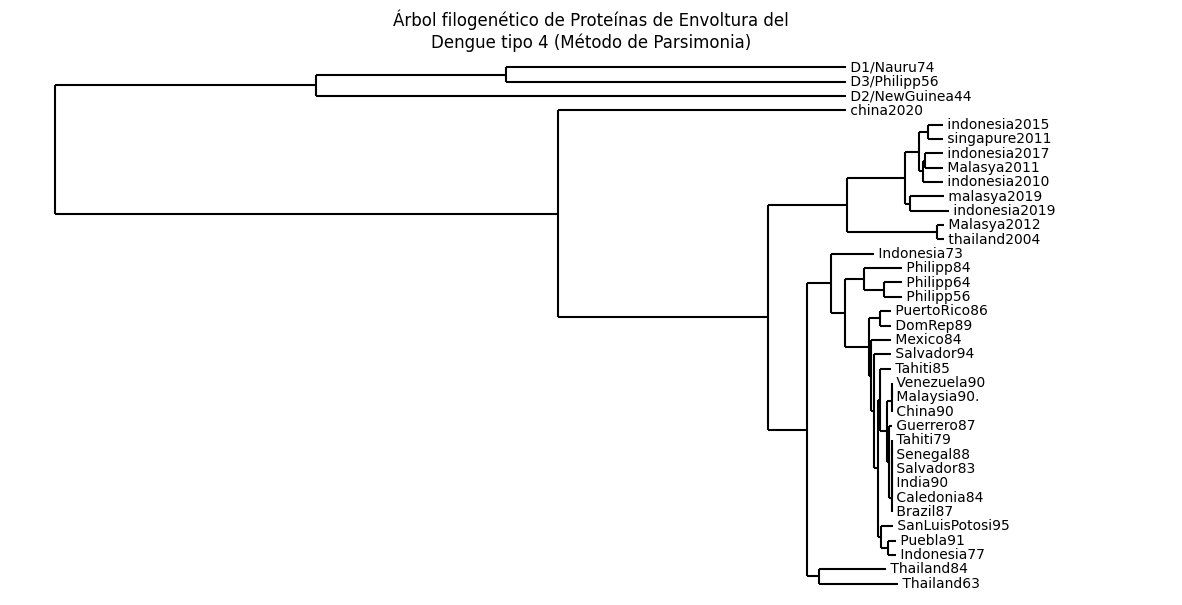

In [92]:
plot_tree(parsimonious_tree, 
          title="Árbol filogenético de Proteínas de Envoltura del\nDengue tipo 4 (Método de Parsimonia)",
          size=(15, 7))